In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
seed_size = 50
batch_sizes = [4]
test_funcs = ["egg", "branin", "hartmann"]
save_file = True

plot_choice_PI = {
        "seq_results": 1, 
        "random_results": 1,
        "random1_results": 1,
        "kb_results": 0,
        "cl_mean_results": 0, 
        "cl_min_results": 1,
        "cl_max_results": 0
        }

label_lookup = {
        "seq_results": "Sequential", 
        "random_results": "Fully Random",
        "random1_results": "Random excl. 1st",
        "kb_results": "Kriging Believer",
        "cl_mean_results": "Constant Liar (Mean)", 
        "cl_min_results": "Constant Liar (Min)",
        "cl_max_results": "Constant Liar (Max)",
        "gpyopt_localp": "Local Penalisation",
        "gpyopt_sequential": "Gpyopt Sequential"
        }

aggr_seed = "mean"

## Fixing PI

In [ ]:
        pickle_dict = {
                "X": self.X, 
                "Y": self.Y, 
                "X_init": self.X_init,
                "Y_init": self.Y_init,
                "PI_values": self.full_PI_value
                }
        
        with open(file_name, 'wb') as f:
            pickle.dump(pickle_dict, f)   

In [ ]:
def fixing_PI_score(func = "egg", seed_size = 2, batch = False, batch_size = 2, heuristic = "sequential"):
    # Calculates cumulative PI score of all queries, which is an indication of 'exploitative-ness'
    
    for i in range(seed_size):
        if batch == False:
            dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential/" \
            + str(i) + "_seed/"
            file_name = dir_name + "sequential,intermediate_vars.pickle"
        
        else:
            dir_name = "Exp_Data/" + func + ',' + str(seed_size) + '_seed,' + str(batch_size) + '_batch_size/' \
            + str(i) + "_seed/"
            file_name = dir_name + heuristic + ',intermediate_vars.pickle'
        
        with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
            pickle_dict = pickle.load(f)
            PI_score = pickle_dict['PI_values']
                       
            # Sequential: self.full_PI_value[:, k] = PI_value
            # Batch: self.full_PI_value[batch number, number within batch, :]
            if batch == True: # If batch, reshape into sequantial format
                PI_score = PI_score.reshape(PI_score.shape[-1], -1)
                
        if all_seed_PI.shape == (0,):
            all_seed_PI = PI_score
        else:
            all_seed_PI = np.vstack((all_seed_PI, PI_score))
            
    if aggr_seed == "mean":
        return np.mean(all_seed_PI, axis = 0)

    if aggr_seed == "median":
        return np.median(all_seed_PI, axis = 0)


## Line Plots

[[1.         0.88406206 0.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         0.82868082 1.         1.         1.
  1.         1.         1.         1.        ]]
[[9.90877608e-001 1.00000000e+000 1.12829327e-012 1.00000000e+000
  2.56771560e-109 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 9.73754392e-001
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+00

[[[0.98476798]
  [0.98343361]
  [0.96843002]
  [0.99312216]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [0.99995725]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [0.99986826]
  [0.9999999 ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [0.99962255]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [0.99656731]]]
[[[0.03734676]
  [0.75135955]
  [0.99459496]
  [0.23281629]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [0.99965756]
  [0.99999973]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[0.99999998]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.   

[[[0.96902287]
  [0.99588931]
  [0.8185417 ]
  [0.88602958]]

 [[0.99806813]
  [0.99925998]
  [0.99818013]
  [0.99999363]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [0.99999861]
  [1.        ]
  [0.99999997]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [0.99998297]
  [1.        ]]]
[[[9.53303350e-01]
  [9.51573560e-01]
  [9.39444515e-01]
  [9.45192904e-01]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [9.99998546e-01]
  [9.99995311e-01]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[6.52461582e-01]
  [1.00000000e+00]
  [7.33979939e-01]
  [1.000000

[[[9.81986129e-001]
  [9.99467440e-001]
  [9.93671950e-001]
  [9.62194842e-001]]

 [[9.99985871e-001]
  [1.00000000e+000]
  [1.00000000e+000]
  [9.99998091e-001]]

 [[9.99942322e-001]
  [9.99941345e-001]
  [9.99943942e-001]
  [9.99890464e-001]]

 [[9.99999960e-001]
  [9.99999951e-001]
  [9.99999975e-001]
  [9.99999874e-001]]

 [[3.61145048e-001]
  [3.29995618e-001]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[9.99569245e-001]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.15565968e-002]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [7.73631547e-121]]

 [[1.00000000e+000]
  [4.14246268e-057]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]]
[[[8.86663888e-01]
  [8.89783305e-01]
  [7.09535788e-01]
  [9.49937121e-01]]

 [[9.99653750e-01]
  [1.00000000e+00]
  [1.00000000e+00]
  [9.99999996e-01]]

 [[9.07266324e-01]
  [9.

[[[9.88383078e-001]
  [9.56623576e-001]
  [9.87559591e-001]
  [8.74374834e-001]]

 [[9.99999825e-001]
  [1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]]

 [[9.99095282e-001]
  [7.51488921e-012]
  [1.00000000e+000]
  [3.05715354e-279]]

 [[9.99742531e-001]
  [9.99974373e-001]
  [9.99991516e-001]
  [9.92872907e-001]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]]

 [[9.95967890e-001]
  [5.13423675e-006]
  [9.99972962e-001]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[9.99999969e-001]
  [9.99999963e-001]
  [9.99999974e-001]
  [9.99999959e-001]]

 [[1.00000000e+000]
  [9.99999999e-001]
  [9.99999989e-001]
  [1.00000000e+000]]]
[[[9.85393404e-01]
  [9.50168444e-01]
  [9.13174755e-01]
  [9.04640299e-01]]

 [[1.00000000e+00]
  [6.41460882e-07]
  [1.00000000e+00]
  [0.00000000e+00]]

 [[9.07510156e-01]
  [1.

  [1.00000000e+00]]]
[[[9.99945855e-001]
  [9.98974983e-001]
  [9.98174131e-001]
  [1.00000000e+000]]

 [[9.93669427e-001]
  [2.57344861e-131]
  [0.00000000e+000]
  [1.00000000e+000]]

 [[9.81416165e-001]
  [9.91241016e-001]
  [9.59452474e-001]
  [9.99999846e-001]]

 [[1.00000000e+000]
  [8.53859416e-002]
  [0.00000000e+000]
  [7.42069849e-011]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[5.85870808e-001]
  [1.00000000e+000]
  [6.47102689e-077]
  [5.80021240e-118]]

 [[1.00000000e+000]
  [4.00691813e-227]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]]
[[[9.99998270e-01]
  [1.00000000e+00]
  [9.99956999e-01]
  [9.99999995e-01]]

 [[9.99998771e-01]
  [9.99998424e-01]
  [9.99998569e-01]
  [9.99998697e-01]]

 [[

cl_min_results
seq_results
Saved as: Exp_Data/Graphs/PI_4-Batch on egg Function (mean, 50 seed).png
[[1.01162133e-002 1.00000000e+000 1.00000000e+000 7.14758386e-122
  1.00000000e+000 1.28959607e-007 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 3.63597903e-001 1.00000000e+000
  9.99796824e-001 1.00000000e+000 9.99999999e-001 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000]]
[[2.09000344e-86 9.98746373e-01 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.43073441e-01
  1.00000000e+00 1.00000000e+00 4.27304074e-03 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.000

[[[0.77803747]
  [0.7129561 ]
  [0.73940017]
  [0.74858578]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [0.70118751]]

 [[0.99501287]
  [0.99990479]
  [1.        ]
  [0.99988076]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]]
[[[0.90430963]
  [0.98713356]
  [0.95638179]
  [0.98715557]]

 [[0.99999686]
  [1.        ]
  [1.        ]
  [0.00156722]]

 [[0.99999995]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.   

  [1.        ]]]
[[[9.01627136e-01]
  [9.63345933e-01]
  [8.89877837e-01]
  [9.12400620e-01]]

 [[9.61596744e-01]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [9.99951590e-01]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [9.91995652e-01]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [9.99999938e-01]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[0.00000000e+00]
  [1.88229337e-14]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]]
[[[9.25459026e-01]
  [9.56676907e-01]
  [9.80354556e-01]
  [9.53884934e-01]]

 [[1.00000000e+00]
  [9.98781527e-01]
  [1.00000000e+00]
  [9.95036065e-01]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.0000

[[[8.93265485e-01]
  [9.38235333e-01]
  [9.27471407e-01]
  [8.81923730e-01]]

 [[6.61651148e-30]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.00000000e+00]]

 [[9.97974242e-01]
  [1.00000000e+00]
  [8.54207420e-38]
  [2.19638957e-04]]

 [[1.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[1.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [0.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [0.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]]
[[[9.79093452e-01]
  [9.47279649e-01]
  [9.16894150e-01]
  [9.99615212e-01]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [0.00000000e+00]
  [1.00

[[[9.47096719e-001]
  [9.15914946e-001]
  [9.51985333e-001]
  [9.33300078e-001]]

 [[9.75282997e-001]
  [9.21771900e-001]
  [8.57403637e-001]
  [1.00000000e+000]]

 [[9.98900293e-001]
  [1.00000000e+000]
  [1.09303593e-035]
  [0.00000000e+000]]

 [[9.99999999e-001]
  [2.48552903e-001]
  [1.00000000e+000]
  [7.26259870e-001]]

 [[1.17183516e-026]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[3.14007704e-288]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.74417855e-213]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]]
[[[9.15669082e-01]
  [7.87287490e-01]
  [7.04588547e-01]
  [6.57630741e-01]]

 [[9.99999856e-01]
  [9.99466810e-01]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [0.

[[[9.40448284e-001]
  [9.28433463e-001]
  [9.34450194e-001]
  [9.42841148e-001]]

 [[9.99996028e-001]
  [1.00000000e+000]
  [9.99999802e-001]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [0.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]
  [1.00000000e+000]]

 [[1.86022953e-100]
  [0.00000000e+000]
  [0.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]
  [1.00000000e+000]]

 [[1.13704475e-007]
  [0.00000000e+000]
  [0.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]
  [0.00000000e+000]]

 [[1.00000000e+000]
  [0.00000000e+000]
  [0.00000000e+000]
  [0.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]]
random_results
random1_results
cl_min_results
seq_results
Saved as: Exp_Data/Graphs/PI_4-Batch on branin Function (mean, 50 seed).png
[[1.         0.99999975 1.         1.         

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  0.99999995 1.         1.         1.         0.99999758 1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.69409076e-237 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 0.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  9.99985833e-001 1.00000000e+000 9.99999944e-001 9.99999999e-001
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  9.

[[[5.58248928e-02]
  [1.00000000e+00]
  [6.14093291e-02]
  [3.97815777e-01]]

 [[4.09159194e-16]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[8.13143262e-67]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[9.93701404e-01]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[0.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[9.61272647e-01]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.60299663e-08]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]]
[[[9.16841749e-003]
  [1.00000000e+000]
  [3.20618907e-001]
  [5.55723128e-005]]

 [[2.86543004e-001]
  [9.45891203e-001]
  [9.89290294e-001]
  [9.99525183e-001]]

 [[6.48090852e-255]
  [1.00000000e+000]
  [1.00000000e+0

[[[9.61616973e-002]
  [1.25063835e-001]
  [9.76077025e-001]
  [3.63140918e-001]]

 [[7.37553483e-003]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[2.73922967e-062]
  [6.58382029e-230]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[9.99999998e-001]
  [5.94782468e-001]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.38610647e-001]
  [9.79180229e-001]
  [9.98252005e-001]
  [9.99999975e-001]]

 [[9.99854246e-001]
  [2.17857858e-017]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[9.10580843e-001]
  [5.41540393e-001]
  [6.38193199e-001]
  [9.99868429e-001]]]
[[[2.21412749e-003]
  [2.85151199e-001]
  [5.97190915e-001]
  [2.03482290e-001]]

 [[1.00000000e+000]
  [6.22373081e-002]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+0

[[[1.09232589e-02]
  [9.99999994e-01]
  [1.76184842e-01]
  [2.69831288e-02]]

 [[9.99997891e-01]
  [4.18818370e-01]
  [8.44715207e-01]
  [8.12211225e-03]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [9.99518622e-01]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[1.00000000e+00]
  [9.66615099e-03]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[0.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[8.89647284e-01]
  [8.35356175e-01]
  [9.20282053e-01]
  [9.61981599e-01]]

 [[9.99996322e-01]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[3.30154781e-28]
  [8.00320266e-01]
  [1.00000000e+00]
  [9.99998351e-01]]

 [[1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]
  [3.99551273e-63]]]
[[[8.06674054e-003]
  [1.30963075e-003]
  [9.75499675e-001]
  [1.00000000e+000]]

 [[1.31693294e-152]
  [2.28367081e-007]
  [6.18786585e-025]
  [6.05225788e-144]]

 [[0.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+0

[[[9.99999152e-001]
  [1.27681057e-001]
  [9.99869758e-001]
  [3.02115279e-001]]

 [[9.32440835e-004]
  [8.13637274e-047]
  [9.99999965e-001]
  [1.00000000e+000]]

 [[0.00000000e+000]
  [9.86190142e-001]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[0.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [4.49189846e-024]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [9.64569403e-001]]

 [[0.00000000e+000]
  [0.00000000e+000]
  [9.90672472e-001]
  [0.00000000e+000]]

 [[4.32271580e-236]
  [1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]]

 [[9.99535593e-001]
  [9.81713088e-001]
  [9.99962543e-001]
  [9.99398350e-001]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[9.14876368e-001]
  [9.95816483e-001]
  [9.92025330e-001]
  [9.99042007e-001]]]
[[[9.99603503e-001]
  [9.99743962e-001]
  [9.99198085e-001]
  [9.99990600e-001]]

 [[9.98475349e-001]
  [9.99252251e-001]
  [9.99877244e-001]
  [9.99481178e-001]]

 [[9.99944737e-0

  [0.00000000e+00]]]
[[[7.14647826e-002]
  [9.14926524e-001]
  [2.72079356e-001]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [2.58325251e-005]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [6.97528363e-010]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[0.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]]

 [[0.00000000e+000]
  [1.00000000e+000]
  [7.77996293e-243]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [0.00000000e+000]
  [0.00000000e+000]]

 [[0.00000000e+000]
  [0.00000000e+000]
  [0.00000000e+000]
  [1.00000000e+000]]

 [[9.99965422e-001]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]

 [[4.66690761e-002]
  [1.00000000e+000]
  [1.00000000e+000]
  [1.00000000e+000]]]
[[[9.31970148e-01]
  [9.91328545e-01]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[2.64553681e-01]
  [9.88219293e-01]
  [9.97068237e-01]
  [9.99993492e-01]]

 [[

[[[9.61616973e-02]
  [3.94101570e-02]
  [5.00395409e-01]
  [1.00000000e+00]]

 [[1.15956794e-33]
  [1.00000000e+00]
  [1.00000000e+00]
  [3.25042045e-17]]

 [[7.72913597e-01]
  [9.58459795e-01]
  [2.91770306e-01]
  [9.99997976e-01]]

 [[1.00000000e+00]
  [9.99120241e-01]
  [9.99999980e-01]
  [9.88350967e-01]]

 [[6.54725135e-01]
  [1.00000000e+00]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[2.36704610e-01]
  [9.99147830e-01]
  [1.00000000e+00]
  [1.00000000e+00]]

 [[9.60569776e-01]
  [5.62978759e-02]
  [2.64064532e-01]
  [4.37330494e-01]]

 [[8.32164413e-01]
  [8.23071520e-01]
  [8.10552898e-01]
  [9.10116943e-01]]

 [[5.93529104e-01]
  [9.99405492e-01]
  [9.05721809e-05]
  [2.31619177e-09]]

 [[5.50253694e-06]
  [9.67125523e-01]
  [1.00000000e+00]
  [2.26949399e-01]]]
[[[2.21412749e-003]
  [1.20459500e-001]
  [1.10595903e-001]
  [9.99994751e-001]]

 [[1.52139841e-047]
  [1.23152098e-001]
  [2.81632068e-013]
  [3.30195366e-003]]

 [[1.00000000e+000]
  [9.99683720e-001]
  [1.15152059e-0

cl_min_results
seq_results
Saved as: Exp_Data/Graphs/PI_4-Batch on hartmann Function (mean, 50 seed).png


<Figure size 432x288 with 0 Axes>

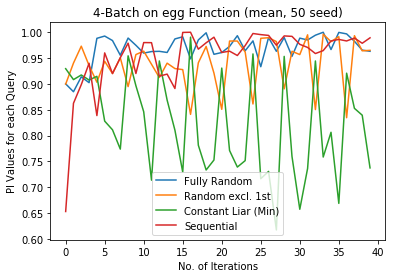

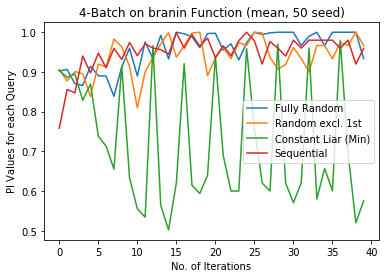

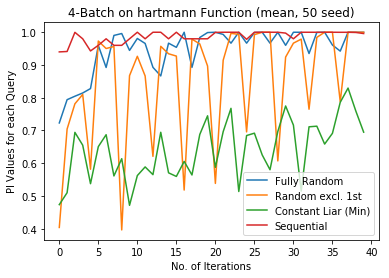

In [4]:
def cumulative_PI_score(func = "egg", seed_size = 2, batch = False, batch_size = 2, heuristic = "sequential", 
                        aggr_seed = aggr_seed):
    # Calculates cumulative PI score of all queries, which is an indication of 'exploitative-ness'
    all_seed_PI = np.array([])
    
    for i in range(seed_size):
        if batch == False:
            dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential/" \
            + str(i) + "_seed/"
            file_name = dir_name + "sequential,intermediate_vars.pickle"
        
        else:
            dir_name = "Exp_Data/" + func + ',' + str(seed_size) + '_seed,' + str(batch_size) + '_batch_size/' \
            + str(i) + "_seed/"
            file_name = dir_name + heuristic + ',intermediate_vars.pickle'
        
        with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
            pickle_dict = pickle.load(f)
            PI_score = pickle_dict['PI_values']
            print(PI_score)
                       
            # Sequential: self.full_PI_value[:, k] = PI_value
            # Batch: self.full_PI_value[batch number, number within batch, :]
            if batch == True: # If batch, reshape into sequantial format
                PI_score = PI_score.reshape(PI_score.shape[-1], -1)
                
        if all_seed_PI.shape == (0,):
            all_seed_PI = PI_score
        else:
            all_seed_PI = np.vstack((all_seed_PI, PI_score))
            
    if aggr_seed == "mean":
        return np.mean(all_seed_PI, axis = 0)

    if aggr_seed == "median":
        return np.median(all_seed_PI, axis = 0)

def plot_cumulative_PI_score(seed_size, batch_sizes, test_funcs, plot_choice, save_file):
    # Loads, plots and saves graphs     
    for batch_size in batch_sizes:
        plt.figure() # New figure
        for func in test_funcs:
            plt.figure() # New figure
            try:
                seq_results = cumulative_PI_score(batch = False, func = func, batch_size = batch_size, seed_size = seed_size)   
            except: pass
            try:
                random_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                     seed_size = 30, heuristic = "random")
            except: pass
            try:
                random1_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                      seed_size = 30, heuristic = "random_except_1st")
            except: pass
            try:
                kb_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                 seed_size = seed_size, heuristic = "kb")
            except: pass
            try:
                cl_mean_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                      seed_size = seed_size, heuristic = "cl-mean")
            except: pass
            try:
                cl_min_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                     seed_size = seed_size, heuristic = "cl-min")
            except: pass
            try:
                cl_max_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                     seed_size = seed_size, heuristic = "cl-max")
            except: pass
            
            no_iterations = seq_results.shape[0]
            
            for key, value in plot_choice.items():
                if value == 1:
                    # fig = sns.lineplot(x = 'iters', y = 'values', data = eval(key), err_style = "band", label = label_lookup[key])
                    print(key)
                    fig = sns.lineplot(x = np.arange(no_iterations), y = eval(key), label = label_lookup[key], estimator = aggr_seed)
            
            graph_title = str(batch_size) + "-Batch on "+ str(func) + " Function " + "(" + str(aggr_seed) + ", " + \
            str(seed_size) + " seed)" 
            ""
            fig.set(xlabel = "No. of Iterations", ylabel = "PI Values for each Query", title = graph_title)
            
            save_path = "Exp_Data/Graphs/" + "PI_" + graph_title + ".png"
            fig2 = fig.get_figure()
            if save_file:
                print("Saved as: " + save_path)
                fig2.savefig(save_path)

plot_cumulative_PI_score(seed_size, batch_sizes, test_funcs, plot_choice_PI, save_file)

In [5]:
random_result

NameError: name 'random_result' is not defined

## Table (to be completed)

In [3]:
def single_PI_score(func = "branin", seed_size = 30, batch = False, batch_size = 2, heuristic = "sequential"):
    # Calculates cumulative PI score of all queries, which is an indication of 'exploitative-ness'
    all_seed_PI = np.array([])
    
    for i in range(seed_size):
        if batch == False:
            dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential" + \
            + str(i) + "_seed/"
            filename = dir_name + "sequential,intermediate_vars.pickle"
        
        else:
            dir_name = "Exp_Data/" + func + ',' + str(seed_size) + '_seed,' + str(batch_size) + '_batch_size/' \
            + str(i) + "_seed/"
            file_name = dir_name + heuristic + ',intermediate_vars.pickle'
        
        try: # in case file does not exist, return 0
            with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
                pickle_dict = pickle.load(f)
                PI_score = pickle_dict['PI_values']

                # Sequential: self.full_PI_value[:, k] = PI_value
                # Batch: self.full_PI_value[batch number, number within batch, :]
                if batch == True: # If batch, reshape into sequantial format
                    PI_score = PI_score.reshape(PI_score.shape[-1], -1)
        except:
            print(file_name + " not found.")
            return 0, 0

        if all_seed_PI.shape == (0,):
            all_seed_PI = PI_score
        else:
            all_seed_PI = np.vstack((all_seed_PI, PI_score))
            
    mean_results = np.mean(all_seed_PI)
    median_results np.median(all_seed_PI)
    
    return mean_results, median_results

def all_PI_score(test_funcs, batch_sizes, seed_size = 30):
    for current_batch_size in batch_sizes:
        for func in test_funcs:
            seq_mean, seq_median = single_PI_score(func = func, seed_size = seed_size, batch = False)
            kb_mean, kb_median = single_PI_score(func = func, seed_size = seed_size, batch = True, batch_size = 
                                                current_batch_size, heuristic = "kb")
            
cumulative_PI_score_table()

SyntaxError: invalid syntax (<ipython-input-3-dc5ab2e40695>, line 33)